PART 1 - CAN NETWORK FIT RANDOM LABELS ??


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
torch.manual_seed(1)

In [6]:
def load_data(training_batch_size, test_batch_size):
    train_dataset = datasets.MNIST('data', train=True, download=True,
                transform=transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1180,), (0.2987,))
                ]))
      # Randomly assign labels to the training set
    random_labels = torch.tensor(np.random.randint(0, 10, (len(train_dataset)), dtype=np.int64))
    train_dataset.targets = random_labels

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)

    test_dataset = datasets.MNIST('data', train=False,
                transform=transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1180,), (0.2987,))
                ]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader


In [7]:
class ModifiedConvNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ModifiedConvNet, self).__init__()
        self.conv1_layer = nn.Conv2d(1, 6, 5)
        self.conv2_layer = nn.Conv2d(6, 16, 5)
        self.fc1_layer = nn.Linear(16 * 5 * 5, 120)
        self.fc2_layer = nn.Linear(120, 84)
        self.fc3_layer = nn.Linear(84, 10)
        self.dropout_layer = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1_layer(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2_layer(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1_layer(x))
        x = self.dropout_layer(x)
        x = F.relu(self.fc2_layer(x))
        x = self.dropout_layer(x)
        x = self.fc3_layer(x)
        return x

In [8]:
def train_model(model, optimizer, train_data_loader, loss_function):
    model.train()
    correct_predictions = 0
    total_loss = 0
    total_batches = 0

    for batch_idx, (data, target) in enumerate(train_data_loader):
        total_batches += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = np.argmax(output.data, axis=1)
        correct_predictions += np.equal(predictions, target.data).sum()

    total_loss = (total_loss * 100) / len(train_data_loader.dataset)
    accuracy = 100.0 * correct_predictions / len(train_data_loader.dataset)
    return total_loss, accuracy

In [15]:
def evaluate_model(model, epoch, test_data_loader, loss_function):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    for data, target in test_data_loader:
        data, target = Variable(data), Variable(target)

        output = model(data)
        loss = loss_function(output, target)
        total_loss += loss.item()

        predictions = np.argmax(output.data, axis=1)
        correct_predictions += np.equal(predictions, target.data).sum()

    total_loss = (total_loss * 100) / len(test_data_loader.dataset)
    accuracy = 100.0 * correct_predictions / len(test_data_loader.dataset)
    print()
    print(f'test set  Epoch {epoch}, Average loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return total_loss

In [16]:
training_batch_size = 100
test_batch_size = 100
training_data_loader, test_data_loader = load_data(training_batch_size, test_batch_size)

modified_model = ModifiedConvNet()

optimizer = optim.Adam(modified_model.parameters(), lr=0.0001)
train_loss_array = []
test_loss_array = []

epochs = 100
log_interval = 500
loss_function = torch.nn.CrossEntropyLoss()

In [17]:
for epoch in range(1, epochs + 1):
    tr_loss, acc = train_model(modified_model, optimizer, training_data_loader, loss_function)
    train_loss_array.append(tr_loss)
    loss_test = evaluate_model(modified_model, epoch, test_data_loader, loss_function)
    test_loss_array.append(loss_test)
    print(f'train set Epoch: {epoch}, Loss: {tr_loss:.4f}, Accuracy: {acc:.2f}%')


test set  Epoch 1, Average loss: 2.3019, Accuracy: 9.42%
train set Epoch: 1, Loss: 2.3042, Accuracy: 10.03%

test set  Epoch 2, Average loss: 2.3029, Accuracy: 9.25%
train set Epoch: 2, Loss: 2.3033, Accuracy: 10.14%

test set  Epoch 3, Average loss: 2.3018, Accuracy: 8.57%
train set Epoch: 3, Loss: 2.3029, Accuracy: 10.03%

test set  Epoch 4, Average loss: 2.3019, Accuracy: 8.71%
train set Epoch: 4, Loss: 2.3028, Accuracy: 10.07%

test set  Epoch 5, Average loss: 2.3023, Accuracy: 7.61%
train set Epoch: 5, Loss: 2.3028, Accuracy: 10.40%

test set  Epoch 6, Average loss: 2.3024, Accuracy: 4.91%
train set Epoch: 6, Loss: 2.3028, Accuracy: 10.17%

test set  Epoch 7, Average loss: 2.3034, Accuracy: 8.69%
train set Epoch: 7, Loss: 2.3026, Accuracy: 10.26%

test set  Epoch 8, Average loss: 2.3027, Accuracy: 8.61%
train set Epoch: 8, Loss: 2.3025, Accuracy: 10.30%

test set  Epoch 9, Average loss: 2.3034, Accuracy: 6.15%
train set Epoch: 9, Loss: 2.3021, Accuracy: 10.54%

test set  Epoch 10

In [18]:
train_loss_list = []
for i in train_loss_array:
    train_loss_list.append(i)
test_loss_list = []
for i in test_loss_array:
    test_loss_list.append(i)

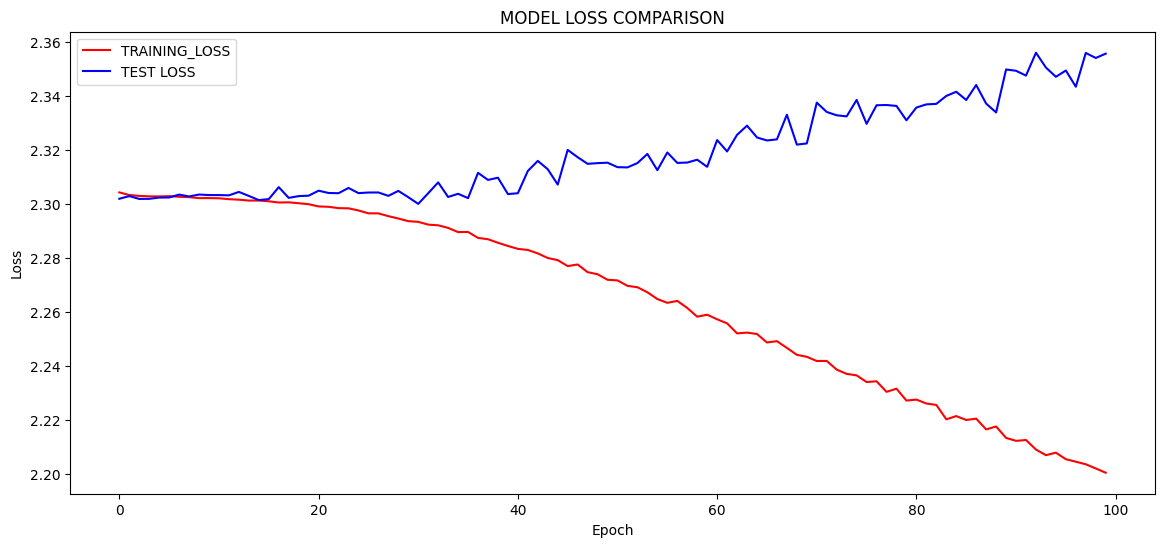

In [19]:
#PLOTTING
plt.figure(figsize=(14, 6))
plt.plot(np.arange(0, 100, 1), train_loss_list, color="red")
plt.plot(np.arange(0, 100, 1), test_loss_list, color="blue")
plt.title('LOSS VS EPOCHS')
plt.legend(['TRAINING', 'TESTING'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

part 2- number of parameters vs generalization

In [20]:
torch.manual_seed(1)

In [21]:
def load_data(train_size, test_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
    train_data = torch.utils.data.DataLoader(trainset, batch_size=train_size, shuffle=True)

    testset = datasets.MNIST('data', train=False, download=True, transform=transform)
    test_data = torch.utils.data.DataLoader(testset, batch_size=test_size, shuffle=True)

    return train_data, test_data

In [22]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 8)
        self.linear3 = nn.Linear(8, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [23]:
def calculate_parameters(model):
    return sum(p.numel() for p in model.parameters())

def initialize_optimizer(model):
    return optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, optimizer, train_data):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        output = model(data.view(-1, 784))
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

def evaluate_model(model, loader):
    correct = 0
    total = 0
    cost_total = 0
    cost_counter = 0
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in loader:
            output = model(data.view(-1, 784))
            cost = loss_fn(output, target)
            cost_total += cost
            cost_counter += 1
            correct += sum(torch.argmax(output, axis=1) == target).item()
            total += len(target)

    return cost_total / cost_counter, correct / total


In [24]:
def train_and_evaluate_models(model, optimizer, train_data, test_data, epochs=8):
    train_loss_arr = []
    test_loss_arr = []
    train_accuracy_arr = []
    test_accuracy_arr = []
    param_arr = []

    for epoch in range(1, epochs + 1):
        train_model(model, optimizer, train_data)

    train_loss, train_acc = evaluate_model(model, train_data)
    test_loss, test_acc = evaluate_model(model, test_data)

    train_loss_arr.append(train_loss)
    test_loss_arr.append(test_loss)
    train_accuracy_arr.append(train_acc)
    test_accuracy_arr.append(test_acc)
    param_arr.append(calculate_parameters(model))

    return train_loss_arr, test_loss_arr, train_accuracy_arr, test_accuracy_arr, param_arr

In [25]:
# Set the batch sizes
train_batch_size = 50
test_batch_size = 100

# Load data
train_data, test_data = load_data(train_batch_size, test_batch_size)

# Initialize models
models = [SimpleModel(784, 5, 10),
          SimpleModel(784, 35, 10),
          SimpleModel(784, 55, 10),
          SimpleModel(784, 75, 10),
          SimpleModel(784, 95, 10),
          SimpleModel(784, 115, 10),
          SimpleModel(784, 135, 10),
          SimpleModel(784, 155, 10),
          SimpleModel(784, 175, 10),
          SimpleModel(784, 195, 10)]

# Initialize lists for storing results
train_loss_arr = []
test_loss_arr = []
train_accuracy_arr = []
test_accuracy_arr = []
param_arr = []

# Train and evaluate models
for i, model in enumerate(models):
    optimizer = initialize_optimizer(model)
    train_loss, test_loss, train_acc, test_acc, param = train_and_evaluate_models(model, optimizer, train_data, test_data)

    train_loss_arr.append(train_loss[0])
    test_loss_arr.append(test_loss[0])
    train_accuracy_arr.append(train_acc)
    test_accuracy_arr.append(test_acc)
    param_arr.append(param[0])

    print(f"Model {i + 1} - Parameters: {param[0]}, Train Loss: {train_loss[0]}, Test Loss: {test_loss[0]}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")


Model 1 - Parameters: 4063, Train Loss: 0.5431169867515564, Test Loss: 0.5437049269676208, Train Accuracy: [0.84115], Test Accuracy: [0.8385]
Model 2 - Parameters: 27853, Train Loss: 0.20597527921199799, Test Loss: 0.2077762931585312, Train Accuracy: [0.9412], Test Accuracy: [0.9405]
Model 3 - Parameters: 43713, Train Loss: 0.18541647493839264, Test Loss: 0.1961487978696823, Train Accuracy: [0.9474], Test Accuracy: [0.9438]
Model 4 - Parameters: 59573, Train Loss: 0.16576941311359406, Test Loss: 0.16830535233020782, Train Accuracy: [0.9544666666666667], Test Accuracy: [0.9515]
Model 5 - Parameters: 75433, Train Loss: 0.15082573890686035, Test Loss: 0.16216684877872467, Train Accuracy: [0.9575666666666667], Test Accuracy: [0.9532]
Model 6 - Parameters: 91293, Train Loss: 0.13861782848834991, Test Loss: 0.14760921895503998, Train Accuracy: [0.96195], Test Accuracy: [0.9576]
Model 7 - Parameters: 107153, Train Loss: 0.12070796638727188, Test Loss: 0.13560432195663452, Train Accuracy: [0.9

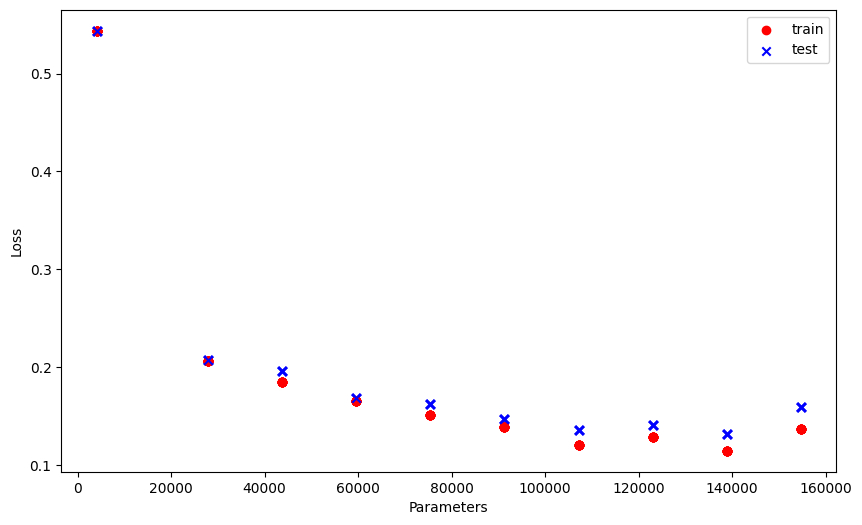

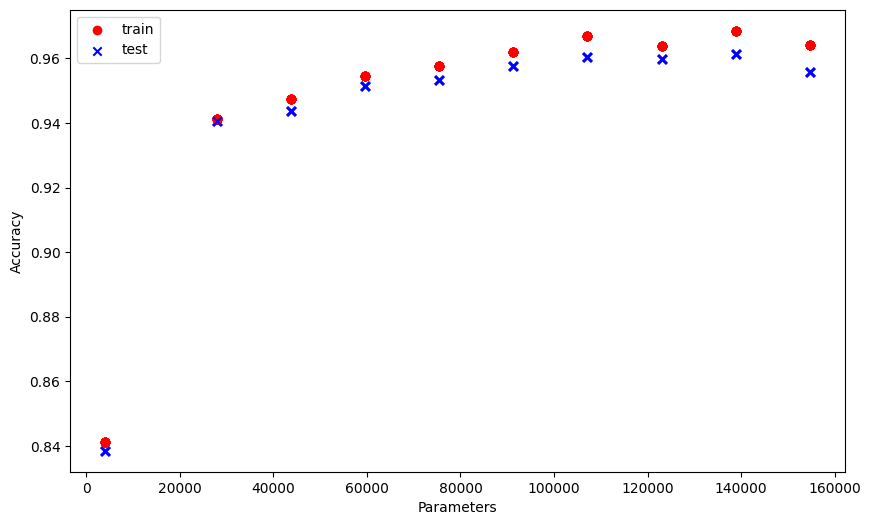

In [26]:
# Plot results manually
plt.figure(figsize=(10, 6))

for i in range(len(models)):
    plt.scatter(param_arr, train_loss_arr, color="red")
    plt.scatter(param_arr, test_loss_arr, color="blue", marker='x')

plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

plt.figure(figsize=(10, 6))

for i in range(len(models)):
    plt.scatter(param_arr, train_accuracy_arr, color='red')
    plt.scatter(param_arr, test_accuracy_arr, color='blue', marker='x')

plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.legend(['train','test'])
plt.show()

Part 3- Flatness vs Genralization PART 1

CROSS ENTROPY LOSS AND ACCURACY VS ALPHA

In [27]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [28]:
torch.manual_seed(1)

In [29]:
# Define the neural network architecture (same as before)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [30]:
# Function to train a model
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
    return train_loss

In [31]:
# Function to evaluate a model on a dataset
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()
    accuracy = correct / total
    return accuracy, total_loss / len(data_loader)

In [32]:
# Linear interpolation function
def linear_interpolation(model1, model2, alpha):
    new_model = SimpleNN()
    new_state_dict = {}
    for key in model1.state_dict():
        new_state_dict[key] = alpha * model1.state_dict()[key] + (1 - alpha) * model2.state_dict()[key]
    new_model.load_state_dict(new_state_dict)
    return new_model

In [33]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [34]:
# Set up data loaders
batch_size_m1 = 64
batch_size_m2 = 1024
train_loader_m1 = DataLoader(mnist_train, batch_size=batch_size_m1, shuffle=True)
train_loader_m2 = DataLoader(mnist_train, batch_size=batch_size_m2, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

In [35]:
# Define the models
model_m1 = SimpleNN()
model_m2 = SimpleNN()

# Define the criterion and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_m1 = optim.Adam(model_m1.parameters(), lr=1e-3)
optimizer_m2 = optim.Adam(model_m2.parameters(), lr=1e-2)

# Train the models
train_loss_m1 = train_model(model_m1, train_loader_m1, criterion, optimizer_m1)
train_loss_m2 = train_model(model_m2, train_loader_m2, criterion, optimizer_m2)

# Evaluate the models on the test set
accuracy_m1, _ = evaluate_model(model_m1, test_loader)
accuracy_m2, _ = evaluate_model(model_m2, test_loader)

In [36]:
# Linear interpolation and evaluation for different interpolation ratios
interpolation_ratios = torch.linspace(0, 1, 11)  # 11 points from 0 to 1
interpolated_accuracies_train = []
interpolated_losses_train = []
interpolated_accuracies_test = []
interpolated_losses_test = []

for alpha in interpolation_ratios:
    interpolated_model = linear_interpolation(model_m1, model_m2, alpha)

    # Evaluate on both training and test sets
    accuracy_train, loss_train = evaluate_model(interpolated_model, train_loader_m1)
    accuracy_test, loss_test = evaluate_model(interpolated_model, test_loader)

    interpolated_accuracies_train.append(accuracy_train)
    interpolated_losses_train.append(loss_train)
    interpolated_accuracies_test.append(accuracy_test)
    interpolated_losses_test.append(loss_test)


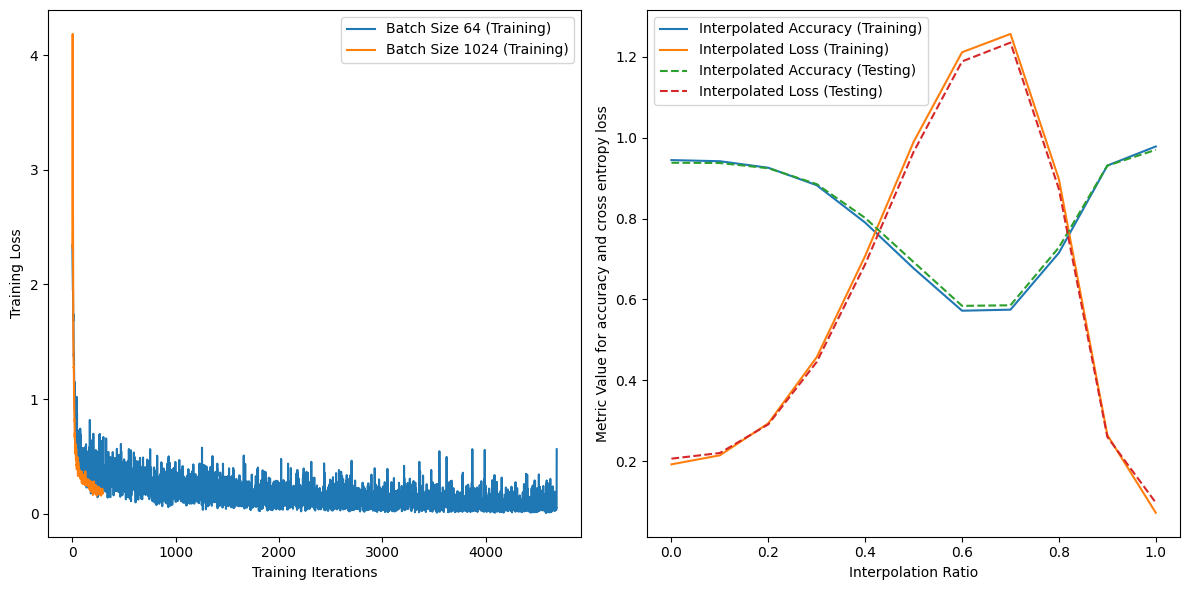

In [37]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_m1, label='Batch Size 64 (Training)')
plt.plot(train_loss_m2, label='Batch Size 1024 (Training)')
plt.xlabel('Training Iterations')
plt.ylabel('Training Loss')
plt.legend()

# Plot interpolated accuracy and loss (training and testing)
plt.subplot(1, 2, 2)
plt.plot(interpolation_ratios.numpy(), interpolated_accuracies_train, label='Interpolated Accuracy (Training)')
plt.plot(interpolation_ratios.numpy(), interpolated_losses_train, label='Interpolated Loss (Training)')
plt.plot(interpolation_ratios.numpy(), interpolated_accuracies_test, linestyle='--', label='Interpolated Accuracy (Testing)')
plt.plot(interpolation_ratios.numpy(), interpolated_losses_test, linestyle='--', label='Interpolated Loss (Testing)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Metric Value for accuracy and cross entropy loss')
plt.legend()

plt.tight_layout()
plt.show()

PART 3 Flatness VS Genrelazation PART 2

Sensitivity and Crossnentropy Loss VS Batch size

In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
torch.manual_seed(1)

In [70]:
# Define the neural network model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [71]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [72]:
# Function to evaluate the model and record metrics
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    sensitivity = np.sum(np.diag(cm)) / np.sum(cm)

    accuracy = correct / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy, sensitivity

In [73]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [74]:
# Define transformations and download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [75]:
# Define batch size for each model
batch_size_per_model = [32, 64, 128, 256, 512]

# Lists to store results
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []
sensitivities = []

# Train and evaluate models for different batch sizes
for batch_size in batch_size_per_model:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Move model to device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_model(model, train_loader, criterion, optimizer)

    # Evaluate on training set
    train_loss, train_accuracy, _ = evaluate_model(model, train_loader)
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    # Evaluate on testing set
    test_loss, test_accuracy, sensitivity = evaluate_model(model, test_loader)
    testing_losses.append(test_loss)
    testing_accuracies.append(test_accuracy)
    sensitivities.append(sensitivity)

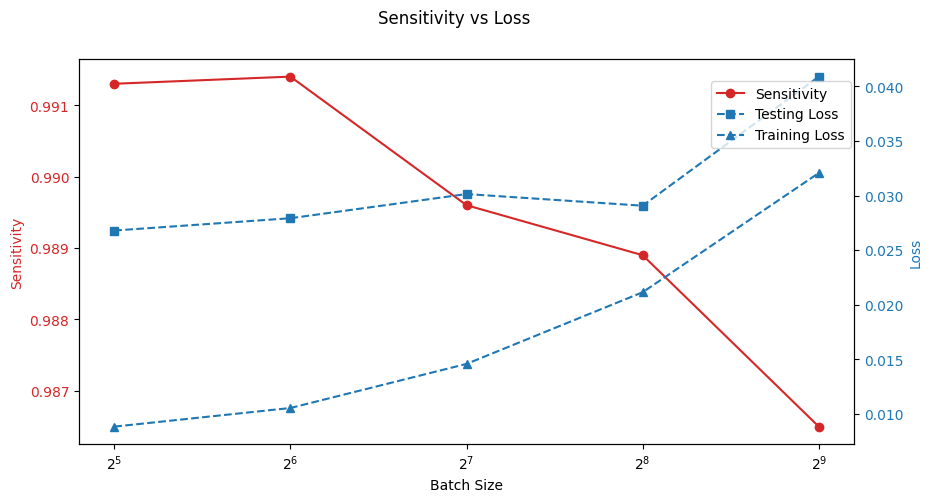

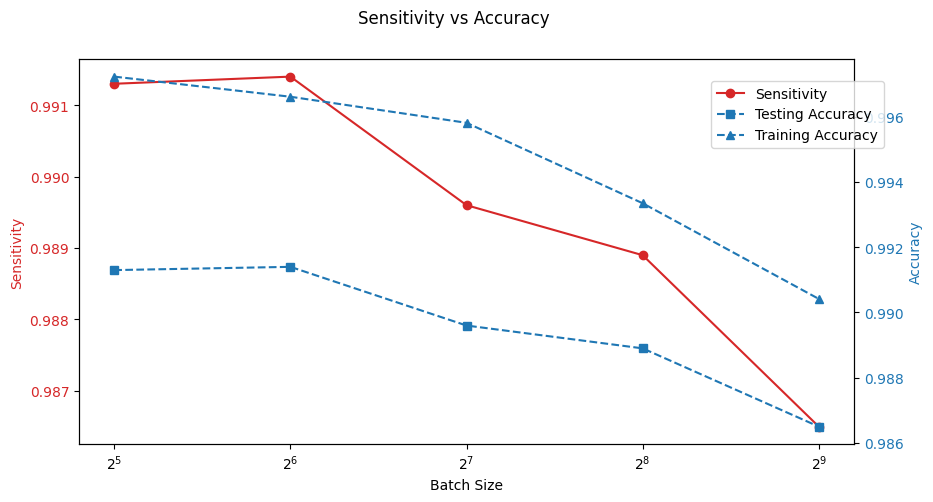

In [77]:
# Plot Sensitivity vs Loss
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Sensitivity', color=color)
ax1.plot(batch_size_per_model, sensitivities, color=color, marker='o', label='Sensitivity')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(batch_size_per_model, testing_losses, color=color, linestyle='dashed', marker='s', label='Testing Loss')
ax2.plot(batch_size_per_model, training_losses, color=color, linestyle='dashed', marker='^', label='Training Loss')
ax2.tick_params(axis='y', labelcolor=color)
plt.xscale('log', base=2)
fig.suptitle('Sensitivity vs Loss')
fig.legend(loc='upper left', bbox_to_anchor=(0.75, 0.85))
plt.show()

# Plot Sensitivity vs Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Sensitivity', color=color)
ax1.plot(batch_size_per_model, sensitivities, color=color, marker='o', label='Sensitivity')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(batch_size_per_model, testing_accuracies, color=color, linestyle='dashed', marker='s', label='Testing Accuracy')
ax2.plot(batch_size_per_model, training_accuracies, color=color, linestyle='dashed', marker='^', label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
plt.xscale('log', base=2)
fig.suptitle('Sensitivity vs Accuracy')
fig.legend(loc='upper left', bbox_to_anchor=(0.75, 0.85))
plt.show()
